In [1]:
import sys
import os
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from CoffeeNet.dataset.dataset import CoffeeDataset
# Train images
train_images_names = os.listdir('../data/processed/images/train/')
# sort
train_mask_names = [image.split('.')[0]+"_mask.png" for image in train_images_names]
# Test images
test_images_names = os.listdir('../data/processed/images/test/')
# sort
test_mask_names = [image.split('.')[0]+"_mask.png" for image in test_images_names]

In [3]:
train_dataframe = pd.DataFrame({'images':train_images_names,'masks':train_mask_names})
test_dataframe = pd.DataFrame({'images':test_images_names,'masks':test_mask_names})

In [4]:
train_dataframe['images'] = train_dataframe['images'].apply(lambda x: os.path.join('../data/processed/images/train/',x))
train_dataframe['masks'] = train_dataframe['masks'].apply(lambda x: os.path.join('../data/processed/annotations/train/',x))

In [5]:
test_dataframe['images'] = test_dataframe['images'].apply(lambda x: os.path.join('../data/processed/images/test/',x))
test_dataframe['masks'] = test_dataframe['masks'].apply(lambda x: os.path.join('../data/processed/annotations/test/',x))

In [6]:
import json
with open('../data/external/annotations-info.json') as f:
    annotation_info = json.load(f)
annotation_info

{'background': [0, 0, 0], 'leaf': [0, 176, 0], 'symptom': [255, 0, 0]}

In [7]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((256,256))])

In [8]:
from models.train import TrainModel
import torch

# Define the data loader
from torch.utils.data import DataLoader
# Get the dataset
train_dataset = CoffeeDataset(train_dataframe,annotation_info,transform)
test_dataset = CoffeeDataset(test_dataframe,annotation_info,transform)
# Get the data loader
train_loader = DataLoader(train_dataset,batch_size=16)
test_loader = DataLoader(test_dataset,batch_size=16)

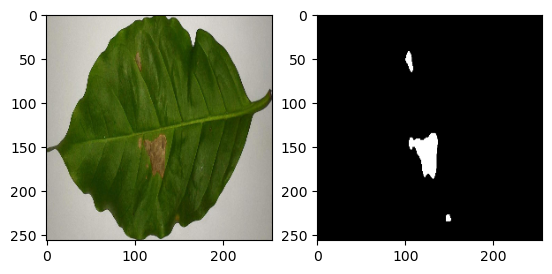

In [9]:
leaf,symptom = train_dataset[93]
leaf,symptom = leaf.cpu().permute(1,2,0),symptom.cpu().permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(leaf,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(symptom,cmap="gray")

In [10]:
# Define the dice loss function
# define dice coefficient and dice loss function
def calc_dice_loss(preds:torch.Tensor,targets:torch.Tensor):
    def dice_coefficient(preds:torch.Tensor,targets:torch.Tensor):
        smooth = 1.0
        assert preds.size() == targets.size()
        
        iflat = preds.contiguous().view(-1)
        tflat = targets.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return 1.0 - dice_coefficient(preds,targets)

In [11]:
from models.elunet.elunet import ELUnet 
elunet_model = ELUnet(3,1,16)

In [12]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
train = TrainModel(elunet_model,test_loader,train_loader,len(train_dataset),len(test_dataset),device)

In [14]:
# Define optimizer
import torch.nn as nn
import torch.optim as optim
opt = optim.Adam(elunet_model.parameters(),lr=3e-4)

In [ ]:
# Train the model for 5 epochs
trained_mode,history = train.train(criterion=calc_dice_loss,optimizer=opt,batch_size=16,num_epoch=100)

In [ ]:
model = elunet_model.to(device)
model.load_state_dict(torch.load("../weights/multi_class/elunet_healthy_leaf_2023-03-10.pth"))


<All keys matched successfully>

/var/folders/wv/vq1czxh12v3g1zl0zl7cklh80000gn/T/ipykernel_13787/3011066551.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


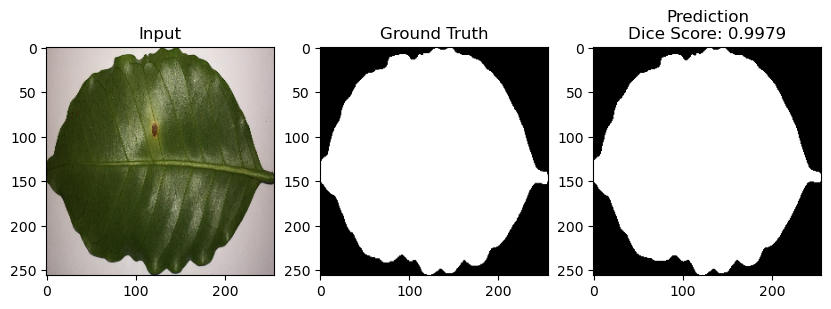

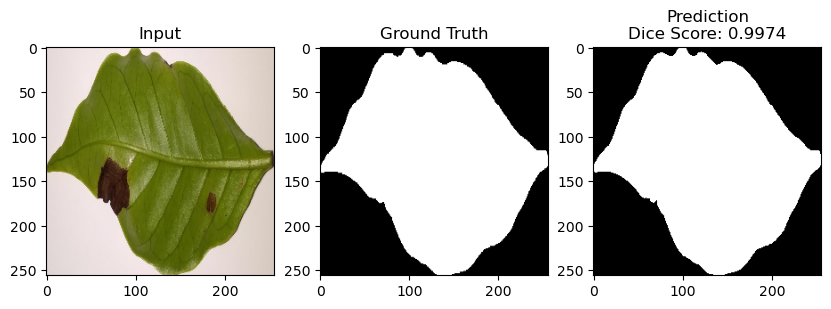

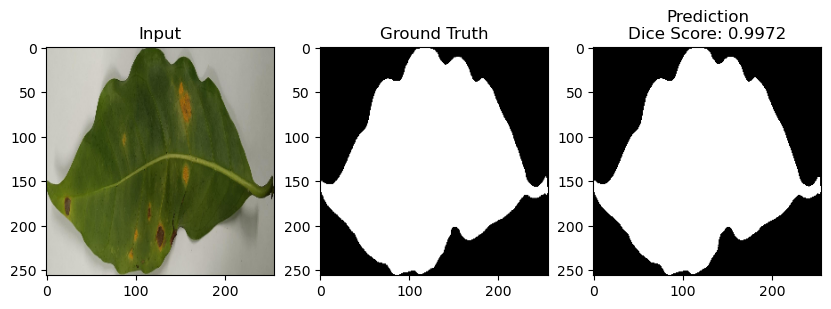

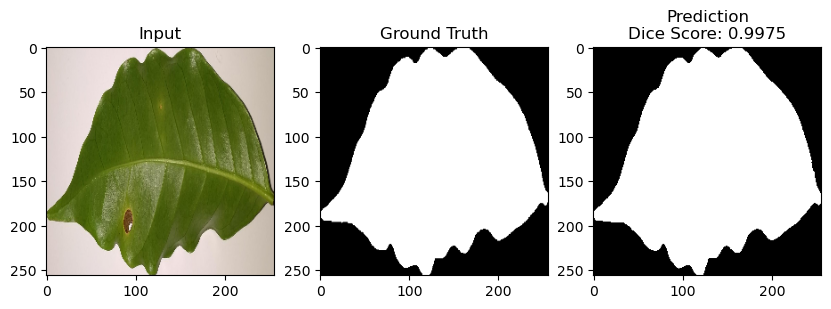

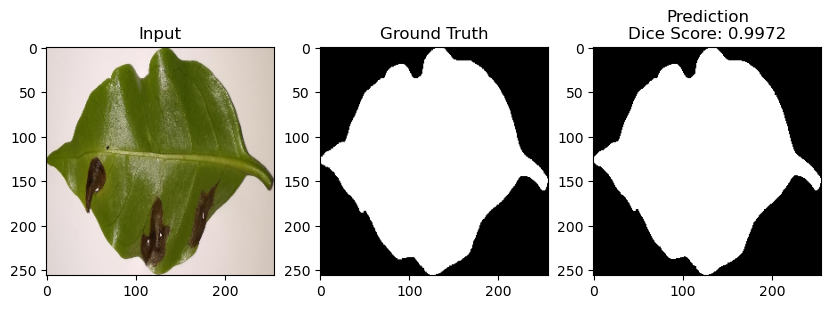

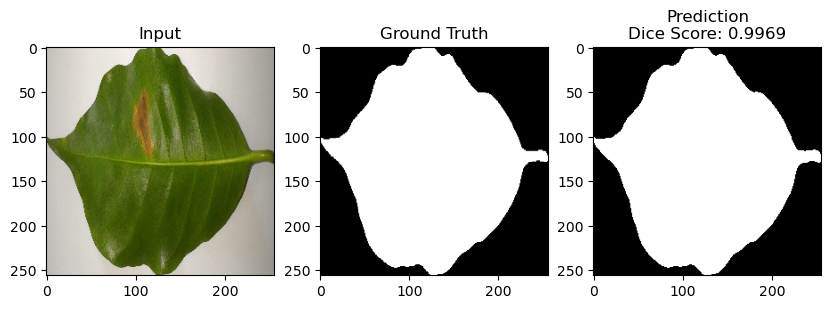

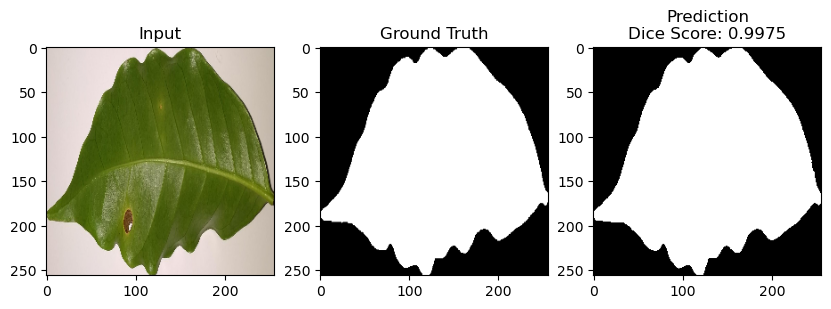

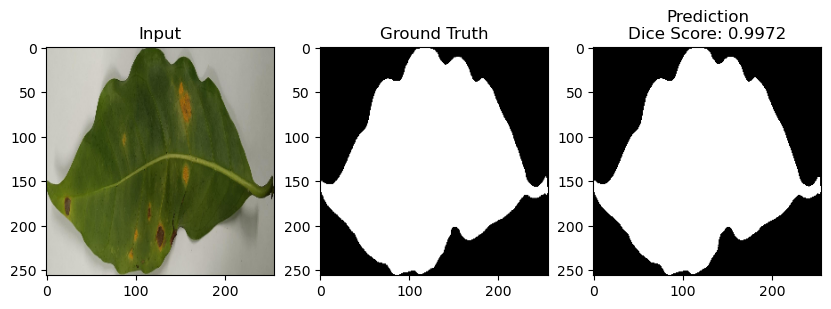

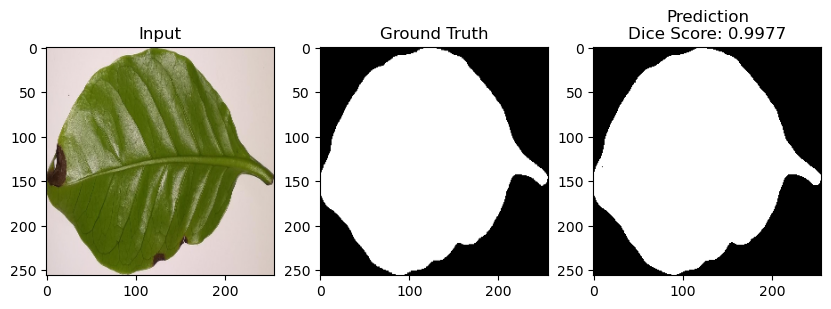

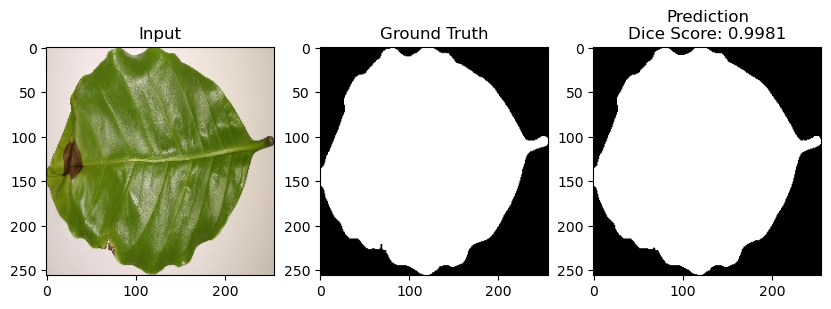

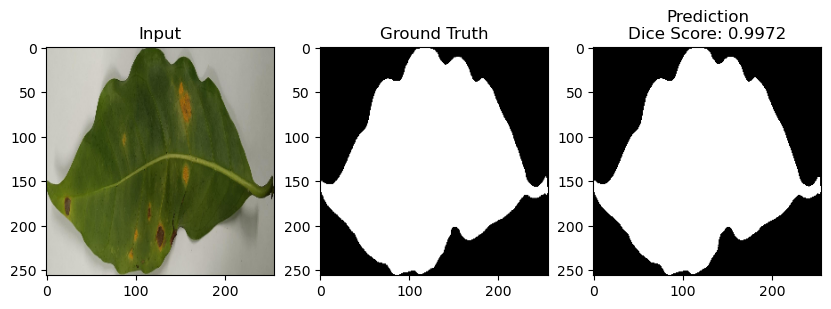

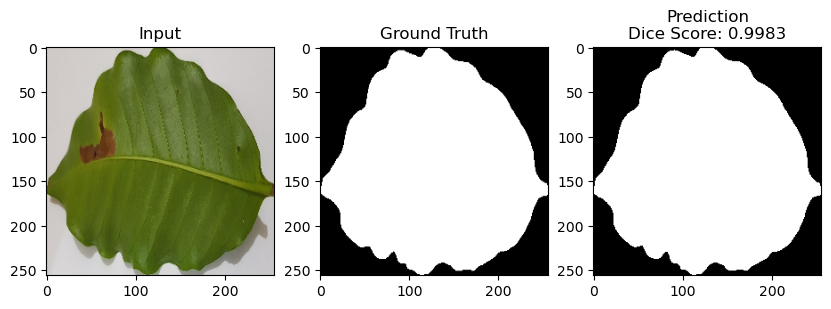

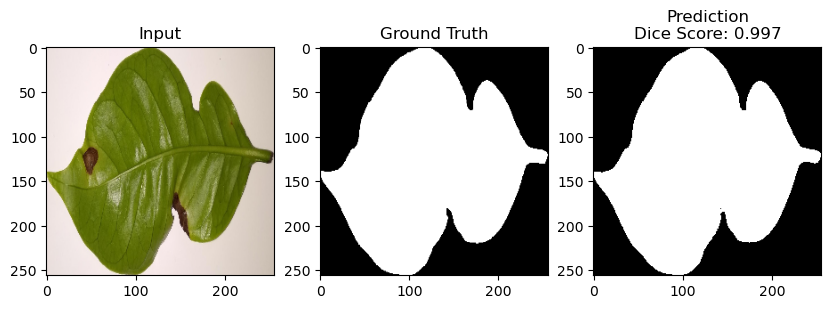

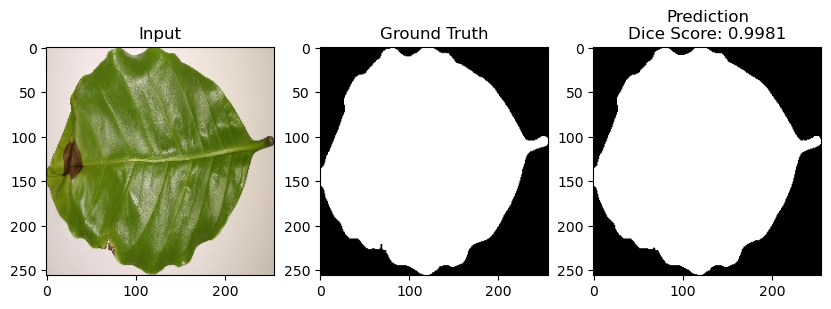

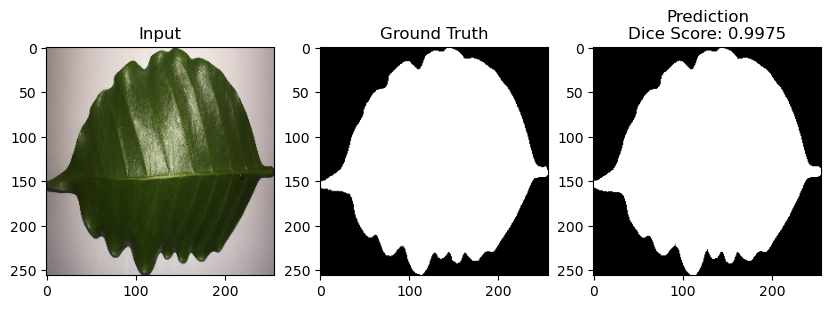

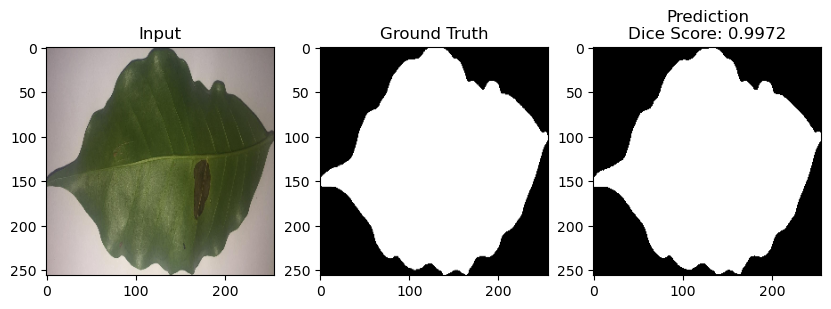

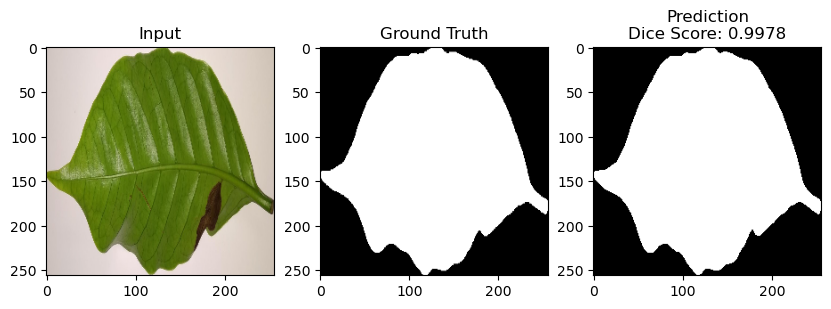

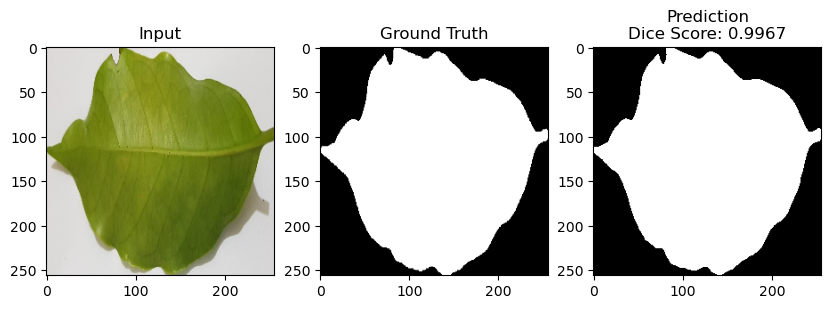

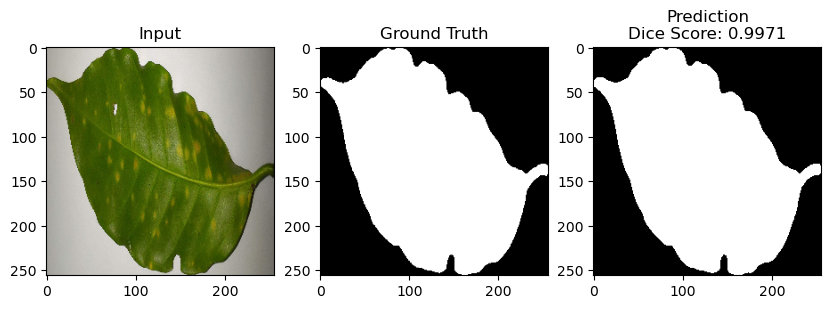

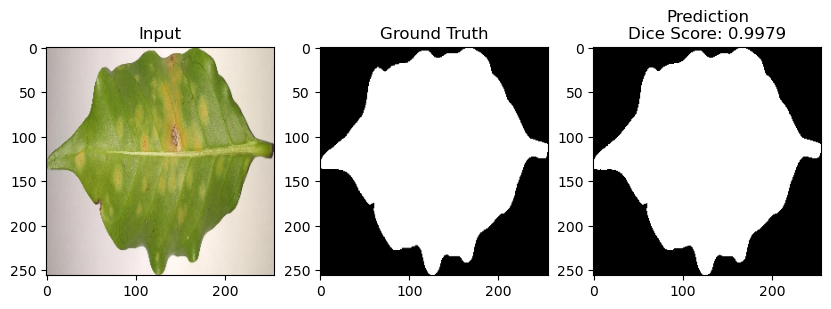

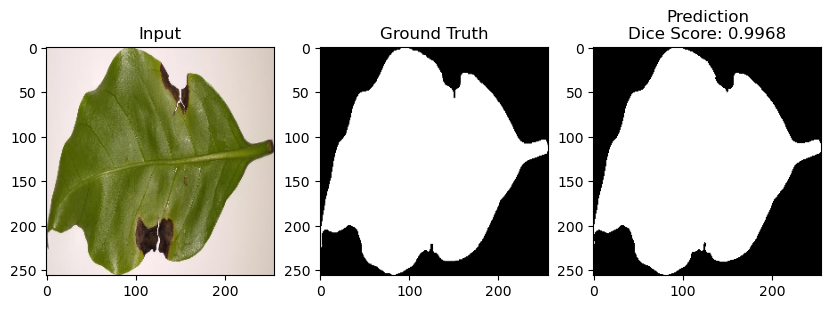

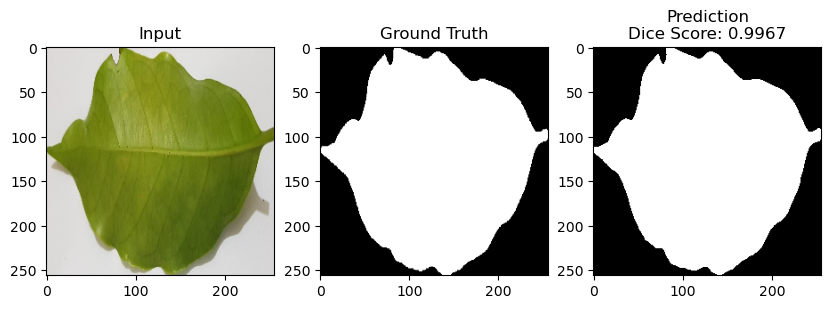

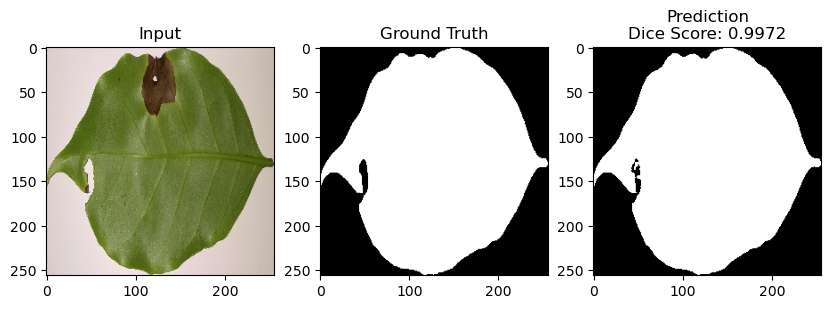

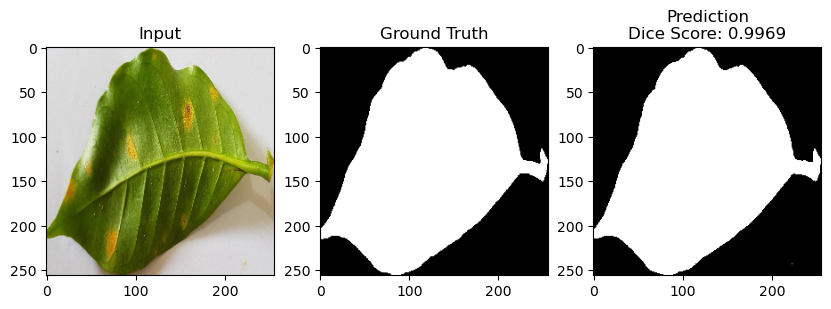

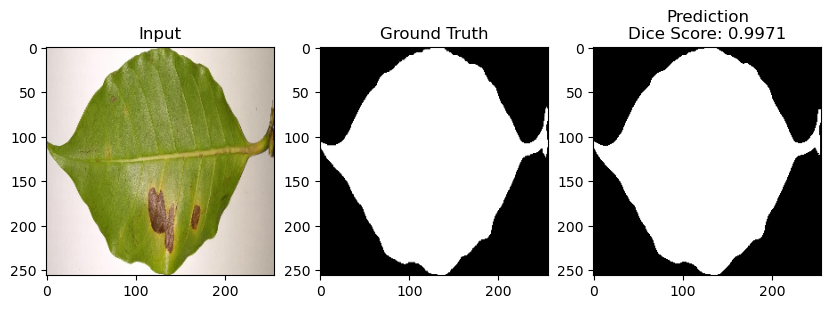

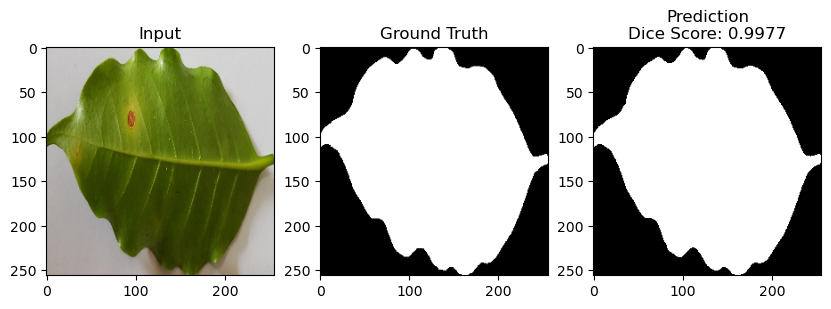

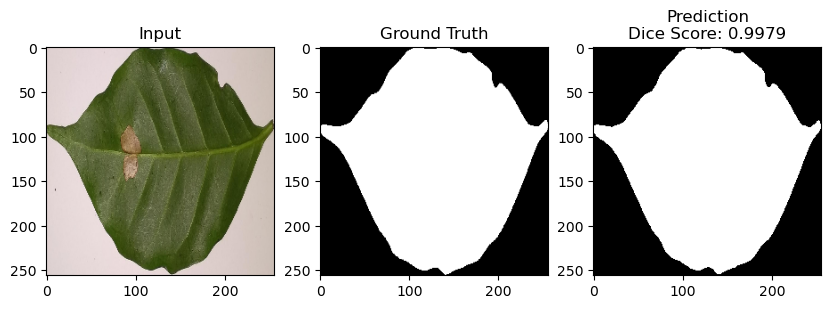

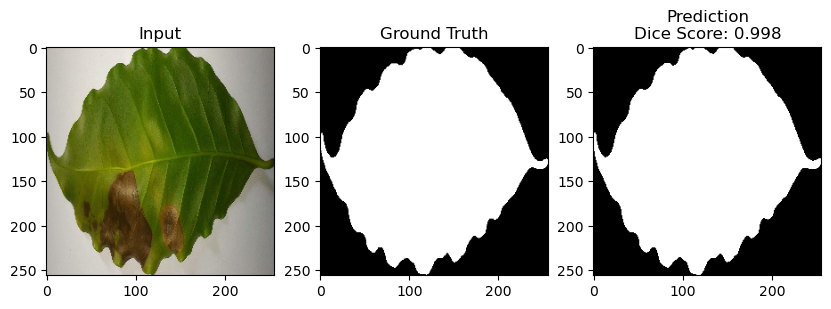

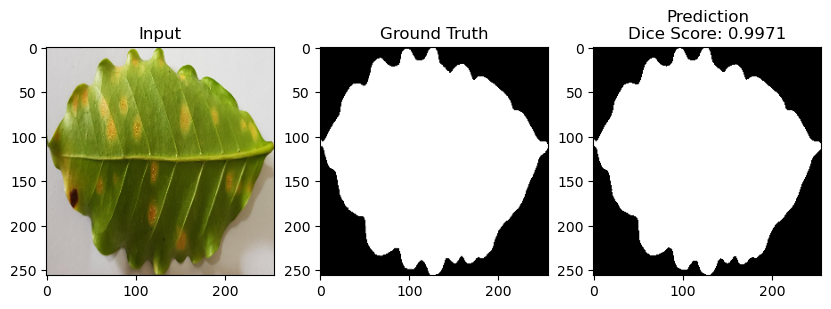

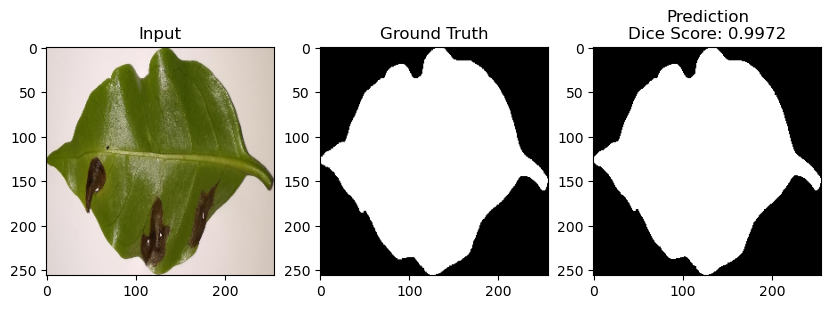

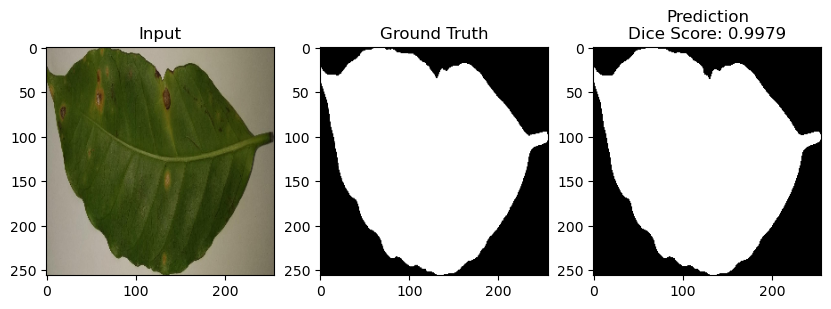

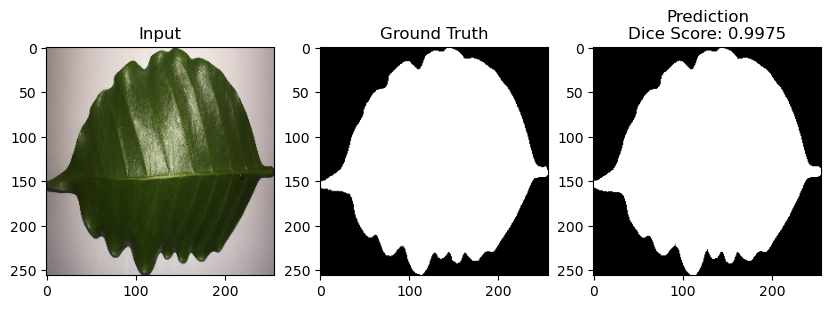

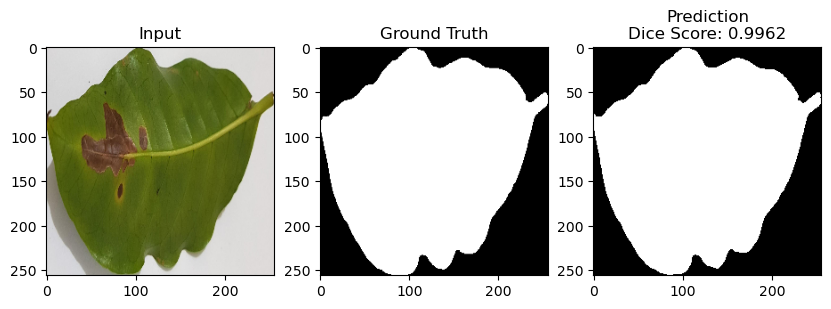

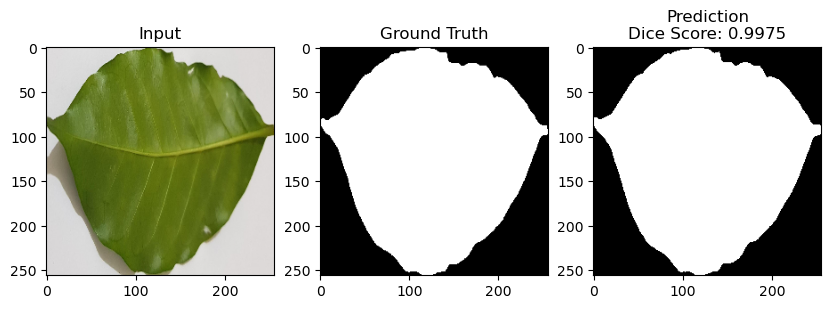

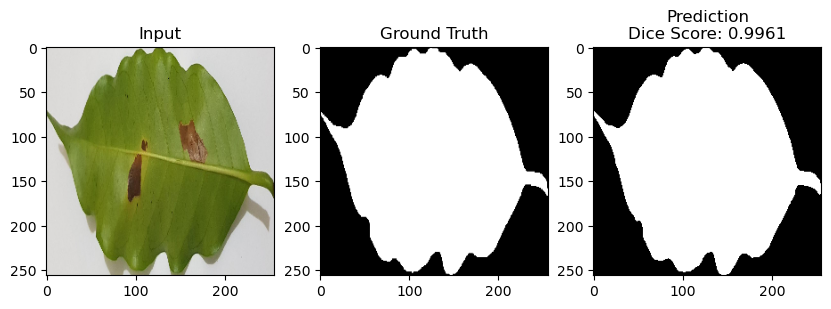

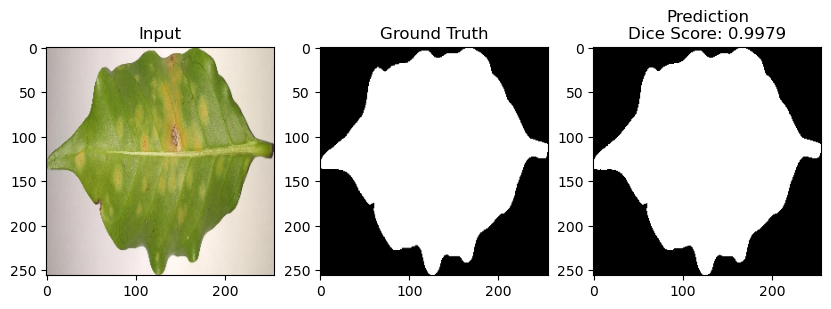

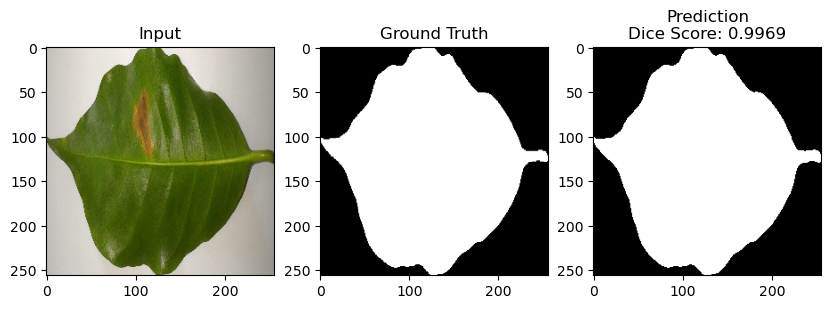

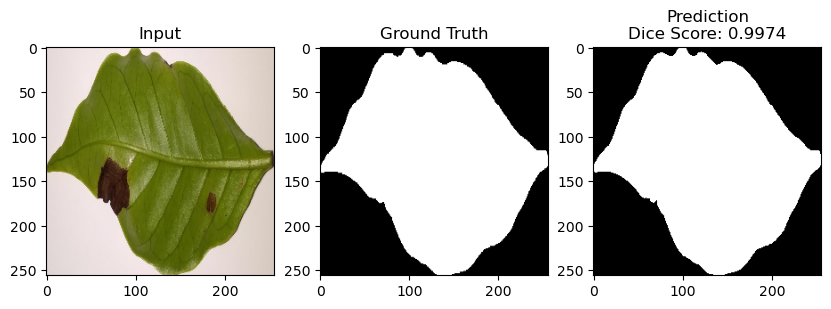

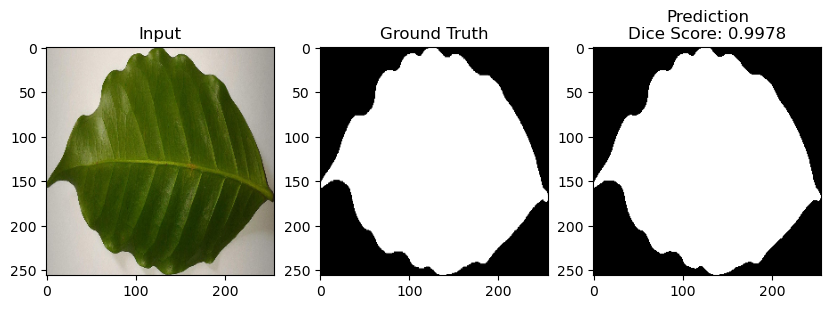

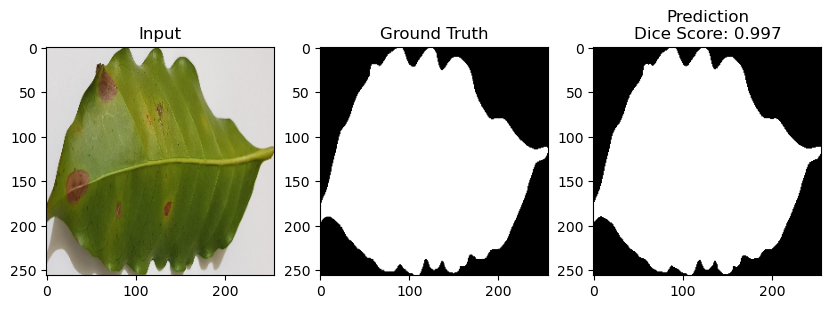

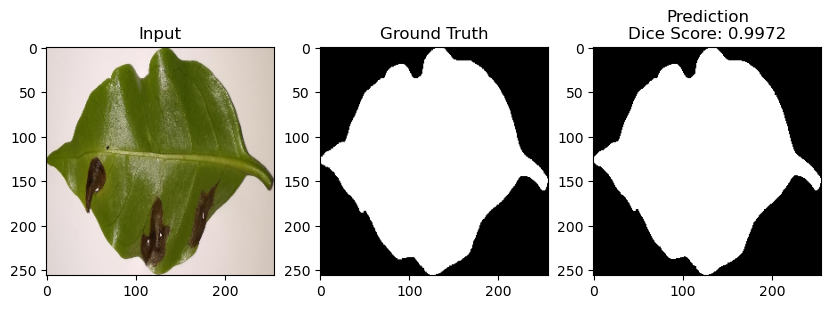

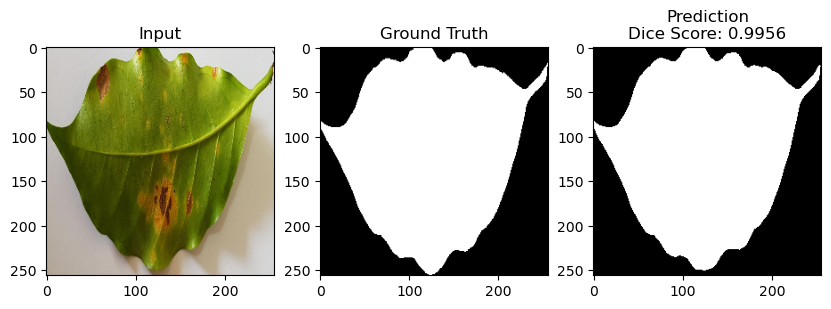

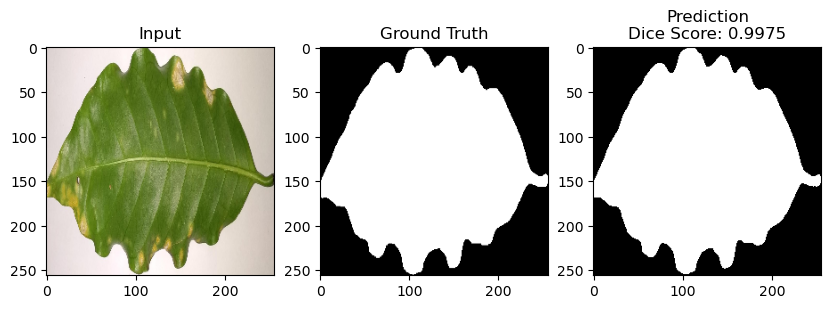

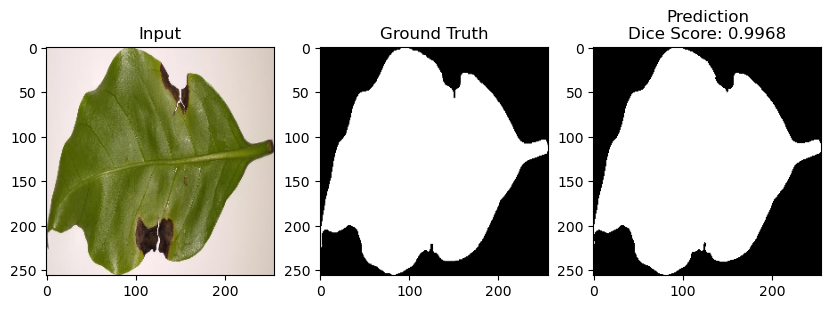

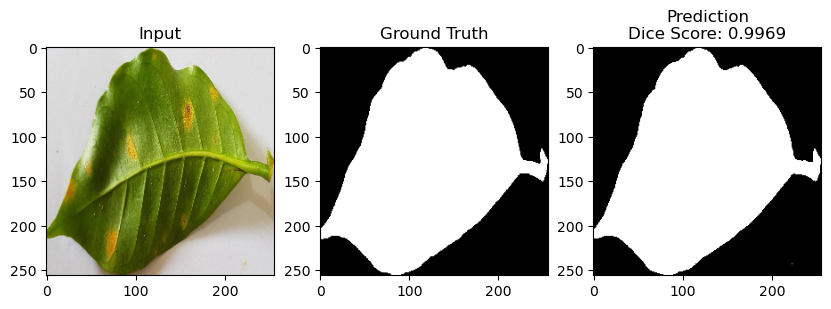

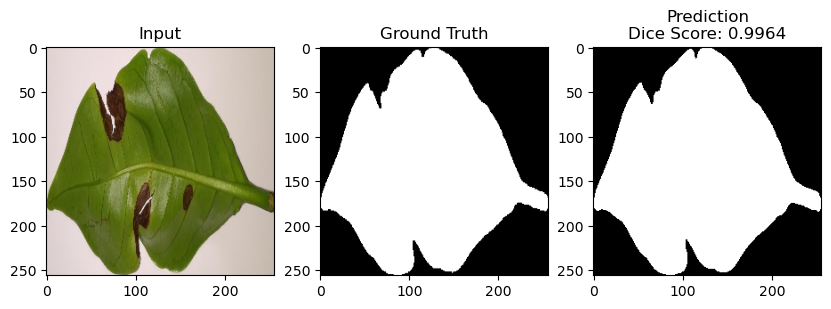

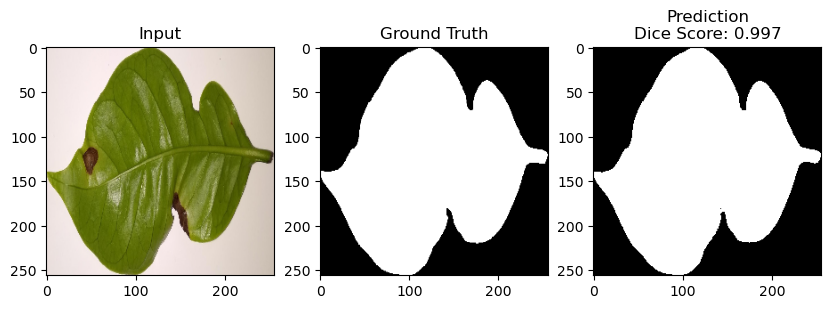

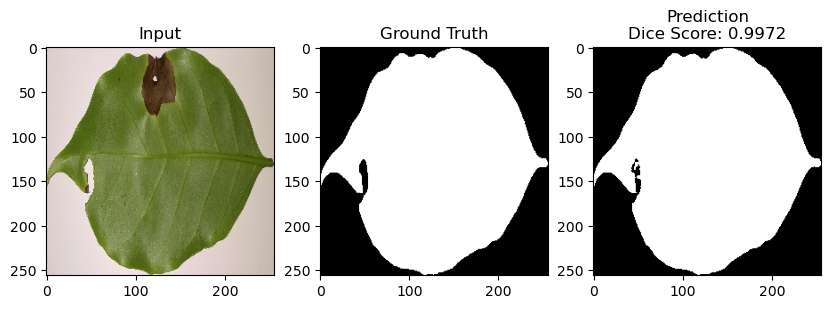

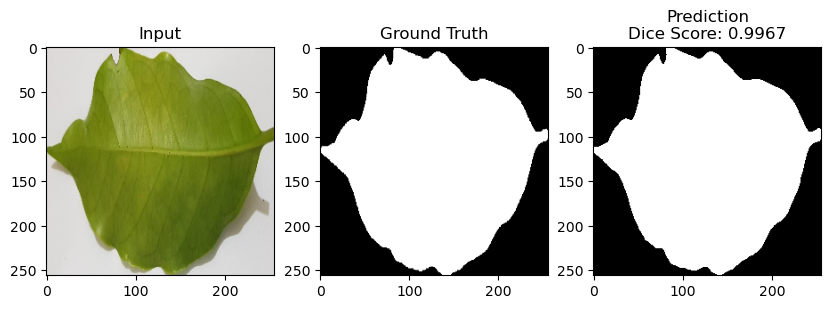

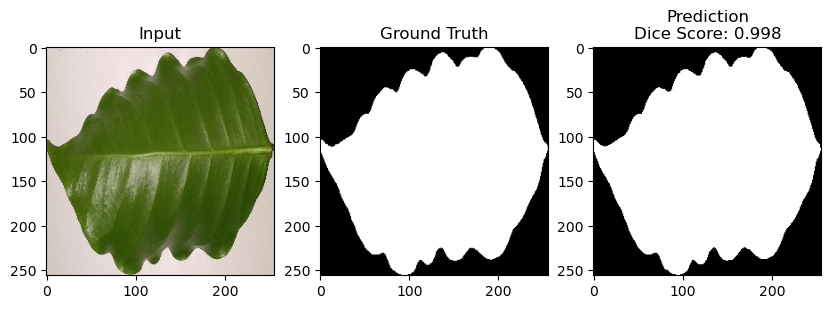

In [ ]:
import random
model.eval()
for i in range(len(test_dataframe)):
    image,mask = CoffeeDataset(test_dataframe,annotation_info,transform)[random.randint(0,len(test_dataframe)-1)]
    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)
    with torch.no_grad():
        image = image.to(device)
        mask = mask.to(device)
        pred = model(image)
        pred = (pred > 0.5).float()
        dice_loss = calc_dice_loss(pred,mask)
        image = image.squeeze(0)
        mask = mask.squeeze(0)
        pred = pred.squeeze(0)
        # Give the figure a title and axis labels
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(image.cpu().permute(1,2,0),cmap="gray")
        plt.title("Input")

        plt.subplot(1,3,2) 
        plt.imshow(mask.cpu().permute(1,2,0),cmap="gray")
        plt.title("Ground Truth")

        plt.subplot(1,3,3)
        plt.imshow(pred.cpu().permute(1,2,0),cmap="gray")
        plt.title(f"Prediction\nDice Score: {round(1-dice_loss.data.item(),4)}")

## Quantize and export El-Unet

In [ ]:
dummy_input = torch.randn(1,3,256,256)

In [ ]:
unet_torchscript = torch.jit.trace(model, dummy_input)

In [ ]:
#Then optimize the TorchScript formatted model for mobile and save it:
from torch.utils.mobile_optimizer import optimize_for_mobile
torchscript_unet_optimized = optimize_for_mobile(unet_torchscript)
torch.jit.save(torchscript_unet_optimized, "healthy_unet2_quantized.pt")

[W TensorImpl.h:1408] Warning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (function operator())
